In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARMA
import warnings, json, math
warnings.filterwarnings('ignore')

In [2]:
sc=SparkContext(appName="covid") 
spark=SparkSession.builder.appName('BDAS_mjia487').getOrCreate()

In [3]:
def create_df_from_csv(file_name):
    df=spark.read.csv(file_name, header=True, inferSchema=True)
    return df

In [4]:
us_train_df = create_df_from_csv('US-train-data.csv')
us_test_df = create_df_from_csv('US-test-data.csv')

In [5]:
print(us_train_df.count())
us_train_df.show()

215
+---------+-----+------+---------+----+
|     date|cases|deaths|recovered|days|
+---------+-----+------+---------+----+
|2020/1/22|    1|     0|        0|   1|
|2020/1/23|    1|     0|        0|   2|
|2020/1/24|    2|     0|        0|   3|
|2020/1/25|    3|     0|        0|   4|
|2020/1/26|    5|     0|        0|   5|
|2020/1/27|    5|     0|        0|   6|
|2020/1/28|    5|     0|        0|   7|
|2020/1/29|    5|     0|        0|   8|
|2020/1/30|    6|     0|        0|   9|
|2020/1/31|    7|     0|        0|  10|
| 2020/2/1|    8|     0|        0|  11|
| 2020/2/2|   11|     0|        0|  12|
| 2020/2/3|   11|     0|        0|  13|
| 2020/2/4|   11|     0|        0|  14|
| 2020/2/5|   12|     0|        0|  15|
| 2020/2/6|   12|     0|        0|  16|
| 2020/2/7|   12|     0|        0|  17|
| 2020/2/8|   12|     0|        0|  18|
| 2020/2/9|   12|     0|        3|  19|
|2020/2/10|   13|     0|        3|  20|
+---------+-----+------+---------+----+
only showing top 20 rows



In [6]:
print(us_test_df.count())
us_test_df.show()

30
+---------+-------+------+---------+----+
|     date|  cases|deaths|recovered|days|
+---------+-------+------+---------+----+
|2020/8/24|5754177|177197|  2020774| 216|
|2020/8/25|5793345|178410|  2053699| 217|
|2020/8/26|5838662|179603|  2084465| 218|
|2020/8/27|5884266|180729|  2101326| 219|
|2020/8/28|5930822|181739|  2118367| 220|
|2020/8/29|5975461|182610|  2140614| 221|
|2020/8/30|6008913|182984|  2153939| 222|
|2020/8/31|6045352|183472|  2184825| 223|
| 2020/9/1|6089379|184563|  2202663| 224|
| 2020/9/2|6121843|185639|  2231757| 225|
| 2020/9/3|6168191|186717|  2266957| 226|
| 2020/9/4|6220292|187697|  2283454| 227|
| 2020/9/5|6262570|188409|  2302187| 228|
| 2020/9/6|6292600|188816|  2315995| 229|
| 2020/9/7|6317773|189079|  2333551| 230|
| 2020/9/8|6346637|189537|  2359111| 231|
| 2020/9/9|6379950|190713|  2387479| 232|
|2020/9/10|6417986|191628|  2403511| 233|
|2020/9/11|6465534|192855|  2417878| 234|
|2020/9/12|6504683|193553|  2434658| 235|
+---------+-------+------+-----

In [7]:
us_train_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- recovered: integer (nullable = true)
 |-- days: integer (nullable = true)



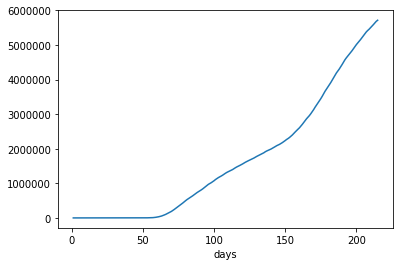

{
    "Critical Value(1%)": -3.4636447617687436,
    "Number of Observations Used": 199,
    "Lags Used": 15,
    "Critical Value(5%)": -2.8761761179270766,
    "Critical Value(10%)": -2.57457158581854,
    "p-value": 0.9934797758877512,
    "Test Statistic Value": 0.9308312683659112
}


In [8]:
us_data_df = us_train_df.toPandas()
time_series_raw = us_data_df['cases']
time_series_raw.index = us_data_df['days']
time_series_raw.plot()
plt.show()
t=sm.tsa.stattools.adfuller(time_series_raw)
output={}
output['Test Statistic Value'] = t[0]
output['p-value'] = t[1]
output['Lags Used'] = t[2]
output['Number of Observations Used'] = t[3]
output['Critical Value(1%)'] = t[4]['1%']
output['Critical Value(5%)'] = t[4]['5%']
output['Critical Value(10%)'] = t[4]['10%']
print(json.dumps(output, indent=4))

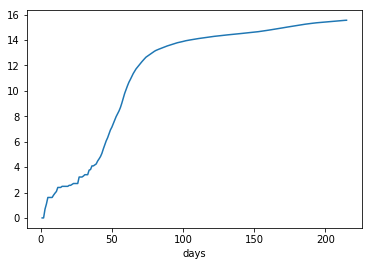

{
    "Critical Value(1%)": -3.4636447617687436,
    "Number of Observations Used": 199,
    "Lags Used": 15,
    "Critical Value(5%)": -2.8761761179270766,
    "Critical Value(10%)": -2.57457158581854,
    "p-value": 0.022419078960072763,
    "Test Statistic Value": -3.160013765486775
}


In [9]:
labels = 'cases'
us_data_df = us_train_df.toPandas()
us_data_df = us_data_df[us_data_df[labels] != 0]
time_series = np.log(us_data_df[labels])
time_series.index = us_data_df['days']
time_series.plot()
plt.show()
t=sm.tsa.stattools.adfuller(time_series)
output={}
output['Test Statistic Value'] = t[0]
output['p-value'] = t[1]
output['Lags Used'] = t[2]
output['Number of Observations Used'] = t[3]
output['Critical Value(1%)'] = t[4]['1%']
output['Critical Value(5%)'] = t[4]['5%']
output['Critical Value(10%)'] = t[4]['10%']
print(json.dumps(output, indent=4))

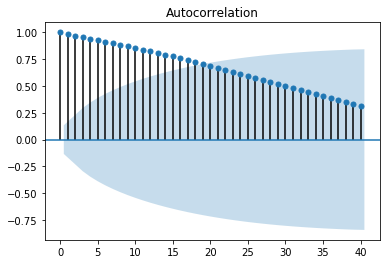

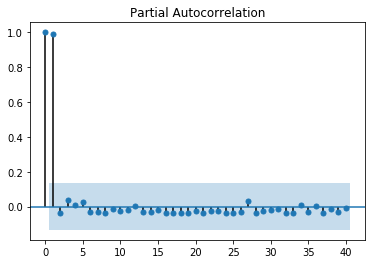

     lag        AC            Q       PAC       Prob(>Q)
0    1.0  0.984797   211.435561  0.984797   6.678394e-48
1    2.0  0.969020   417.111724 -0.026700   2.662808e-91
2    3.0  0.954279   617.518857  0.026719  1.604910e-133
3    4.0  0.939999   812.894531  0.006416  1.236707e-174
4    5.0  0.926403  1003.563072  0.015948  1.017375e-214
5    6.0  0.912331  1189.367752 -0.022800  9.573640e-254
6    7.0  0.897772  1370.154810 -0.021134  1.106679e-291
7    8.0  0.882686  1545.761231 -0.025052   0.000000e+00
8    9.0  0.867547  1716.218933 -0.010028   0.000000e+00
9   10.0  0.852278  1881.531833 -0.014635   0.000000e+00
10  11.0  0.836900  2041.714196 -0.012721   0.000000e+00
11  12.0  0.821838  2196.943949  0.001559   0.000000e+00
12  13.0  0.806361  2347.121693 -0.022271   0.000000e+00
13  14.0  0.790483  2492.161432 -0.020469   0.000000e+00
14  15.0  0.774420  2632.062513 -0.014924   0.000000e+00
15  16.0  0.757952  2766.750284 -0.022758   0.000000e+00
16  17.0  0.741110  2896.169260

In [10]:
plot_acf(time_series, lags=40)
plot_pacf(time_series, lags=40)
plt.show()
r,rac,Q = sm.tsa.acf(time_series, qstat=True)
prac = pacf(time_series,method='ywmle')
table_data = np.c_[range(1,len(r)), r[1:],rac,prac[1:len(rac)+1],Q]
table = pd.DataFrame(table_data, columns=['lag', "AC","Q", "PAC", "Prob(>Q)"])
print(table)

In [11]:
(p, q) =(sm.tsa.arma_order_select_ic(time_series,max_ar=3,max_ma=3,ic='aic')['aic_min_order'])

In [12]:
p,q

(2, 1)

In [13]:
arma_mod = ARMA(time_series,(p,q)).fit(disp=-1,method='mle')
summary = (arma_mod.summary2(alpha=.05, float_format="%.8f"))
print(summary)

                           Results: ARMA
Model:              ARMA             BIC:                 -437.4979
Dependent Variable: cases            Log-Likelihood:      232.18   
Date:               2020-10-22 11:19 Scale:               1.0000   
No. Observations:   215              Method:              mle      
Df Model:           4                Sample:              0        
Df Residuals:       211                                   5        
Converged:          1.0000           S.D. of innovations: 0.080    
No. Iterations:     38.0000          HQIC:                -447.542 
AIC:                -454.3511                                      
-------------------------------------------------------------------
                 Coef.  Std.Err.     t      P>|t|   [0.025   0.975]
-------------------------------------------------------------------
const           11.1627  21.4514     0.5204 0.6028 -30.8811 53.2066
ar.L1.cases      1.9851   0.0007  3020.3336 0.0000   1.9838  1.9864
ar.L2.c

In [14]:
arma_mod = ARMA(time_series,(p, q)).fit(disp=-1,method='mle')
resid = arma_mod.resid
t=sm.tsa.stattools.adfuller(resid)
output={}
output['Test Statistic Value'] = t[0]
output['p-value'] = t[1]
output['Lags Used'] = t[2]
output['Number of Observations Used'] = t[3]
output['Critical Value(1%)'] = t[4]['1%']
output['Critical Value(5%)'] = t[4]['5%']
output['Critical Value(10%)'] = t[4]['10%']
print(json.dumps(output, indent=4))

{
    "Critical Value(1%)": -3.463476079125,
    "Number of Observations Used": 200,
    "Lags Used": 14,
    "Critical Value(5%)": -2.876102355,
    "Critical Value(10%)": -2.574532225,
    "p-value": 0.0015414347956244638,
    "Test Statistic Value": -3.9760166938180084
}


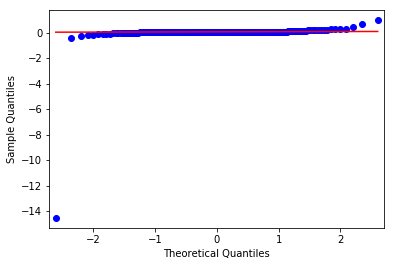

In [15]:
from statsmodels.graphics.api import qqplot
fig = qqplot(resid, line='q', fit=True)
plt.show()

In [16]:
print(sm.stats.durbin_watson(resid.values))

1.0099143055494826


In [17]:
arma_model = sm.tsa.ARMA(time_series,(p,q)).fit(disp=-1,maxiter=100)

In [18]:
predict_data = np.exp(arma_model.predict(start=1, end=245, dynamic = False))[-30:]

In [19]:
test_days = us_test_df.toPandas()['days']
test_data = np.array(us_test_df.toPandas()[labels])

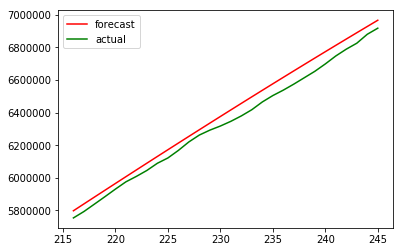

MAE: 56130.0065 
relative MAE: 0.0088


In [20]:
plt.plot(test_days, predict_data, color='r', label='forecast')
plt.plot(test_days, test_data, color='g', label='actual')
plt.legend()
plt.show()

mae = np.mean(np.fabs(predict_data -test_data))
rel_mae = np.mean(np.fabs(predict_data -test_data)/test_data)
print('MAE: %.4f ' % mae)
print('relative MAE: %.4f' % rel_mae)

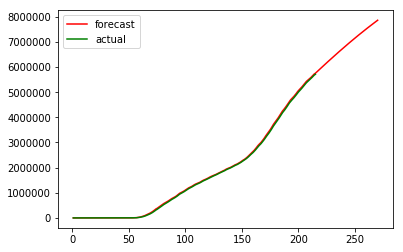

In [21]:
predict_data_all = np.exp(arma_model.predict(start=1, end=270, dynamic = False))
train_days = us_train_df.toPandas()['days']
train_data = np.array(us_train_df.toPandas()[labels])
plt.plot(np.arange(len(predict_data_all)) + 1, predict_data_all, color='r', label='forecast')
plt.plot(train_days, train_data, color='g', label='actual')
plt.legend()
plt.show()